## Note 3 Polyushka polye

In [2]:
import pydub
import numpy as np
import sounddevice as sd
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
import cv2 as cv
import pandas as pd

In [3]:
def detectNotes(img, template, threshold):
    img2 = img.copy()
    
    w, h = template.shape[::-1]

    res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
    loc = np.where( res >= threshold)
    
    rects = list(zip(*loc[::-1]))
    rects = sorted(rects, key = lambda x: (x[0], x[1]))
    rects = np.asarray(rects)
    
    keep = [0]
    x_margin = 20
    y_margin = 20
    prev_x = rects[0][0]
    prev_y = rects[0][1]

    for i in range(1, rects.shape[0]):
        if (abs(rects[i][0] - prev_x) > x_margin or abs(rects[i][1] - prev_y) > y_margin):
            keep.append(i)
            prev_x = rects[i][0]
            prev_y = rects[i][1]

    rects = rects[keep]
    rect2=[]
    for i in rects:
       # if(rect2==[]):
        #    rect2.append(i)
        a=1    
        for j in range (len(rect2)):
             if(   ((i[0]-rect2[j][0])**2)+((i[1]-rect2[j][1])**2)<20 ):
               a=0
        if(a):
            rect2.append(i)   
        for pt in rects:
            cv.rectangle(img2, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)
        
    return rect2, img2

In [4]:
# detect lines
def LineDetector(input_im):
# convert image to gray image
    Gray_IM = cv.cvtColor(input_im,cv.COLOR_BGR2GRAY)
# detect edges
    t_lower = 50  # Lower Threshold
    t_upper = 200  # Upper threshold
#apertureSize is an optional parameter that is used to specify the order of the Sobel filter used
#to calculate the gradient in the Canny algorithm. The default value is 3 and its value should 
#be odd between 3 and 7. You can increase the Aperture size when you want to detect more detailed features.
    edges = cv.Canny(Gray_IM,t_lower,t_upper,apertureSize=3)

    IM_lines = cv.HoughLinesP(
                edges,
                1, # Distance resolution in pixels
                np.pi/180, # Angle resolution in radians
                threshold=50, # Min number of votes for valid line
                minLineLength=40, # Min allowed length of line
                maxLineGap=10 # Max allowed gap between line for joining them
                )
    lines_Y=[]
    for line in IM_lines:
        xx,ys,xf,yf=line[0]
        if(abs(xx-xf)>50):
            if(abs(ys-yf)<5):
                a=1
                for i in lines_Y:
                    if(abs(i-ys)<5):
                        a=0
                if(a or lines_Y==[]):
                    lines_Y.append(ys)
    for i in lines_Y:
        cv.line(Gray_IM, (0, i), (1700, i), (0,0,255), 2, cv.LINE_AA)
    lines_Y.sort()    
    return Gray_IM,lines_Y    
         


1


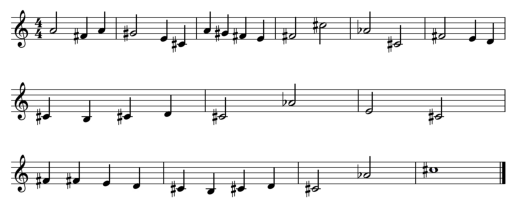

In [34]:
Ave_image = cv.imread('polyushka.png',cv.IMREAD_GRAYSCALE)
Ave_image1 = cv.imread('polyushka.png')
template2 = cv.imread("whole.PNG", cv.IMREAD_GRAYSCALE)
threshold2 = 0.55

rects_part2, img3 = detectNotes(Ave_image, template2, threshold2)
linesim,lines=LineDetector(Ave_image1)
print(len(rects_part2))
for i in rects_part2:
    cv.circle(Ave_image1, (i[0]+14,i[1]+11), radius=0, color=(0,0 , 255), thickness=2)

_ = plt.imshow(Ave_image1, cmap = plt.cm.gray)
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.box(0)

In [39]:
# note class
class DorB:
    def __init__(self,x,y,Dbolean):
        self.x=x
        self.y=y
        self.D=Dbolean

class note :
    def __init__(self):
        self.x=0
        self.y=0
        self.id=0
        self.octave=0
        self.dur=0
class blunt :
    def __init__(self):
        self.lines=[]
        self.average=0
        self.notes=[]
        self.extra=[]
    def AddExtraToNote(self):
        for i in self.extra:
            min=100
            index=0
            for j in range(len(self.notes)):
                if( (abs(i.x)-self.notes[j].x )<min):
                    min=(abs(i.x)-self.notes[j].x )
                    index=j
            if(i.D==1):
                if(self.notes[index].id==11):
                    self.notes[index].id=0
                    self.notes[index].octave=self.notes[index].octave+1
                else:
                    self.notes[index].id=self.notes[index].id+1
            else:
                if(self.notes[index].id==0):
                    self.notes[index].id=11
                    self.notes[index].octave=self.notes[index].octave-1
                else:
                    self.notes[index].id=self.notes[index].id+1 
    def findNotesStr(self):
       HLD=int(np.rint((self.lines[4]-self.lines[0])/8))
       notelevel=[
           self.lines[0]-2*HLD,
           self.lines[0]-HLD,
           self.lines[0],
           self.lines[1]-HLD,
           self.lines[1],
           self.lines[2]-HLD,
           self.lines[2],
           self.lines[3]-HLD,
           self.lines[3],
           self.lines[4]-HLD,
           self.lines[4],
           self.lines[4]+HLD,
           self.lines[4]+2*HLD,
           self.lines[4]+(4*HLD+1)
       ]
       index=pd.Index(notelevel)
       for note in self.notes:
           a=index.get_indexer([note.y], method="nearest")
           if(a==0):
               note.octave=5
               note.id=0
           elif (a==1):
               note.octave=5
               note.id=10
           elif (a==2):
               note.octave=5
               note.id=8
           elif (a==3):
               note.octave=5
               note.id=7
           elif (a==4):
               note.octave=5
               note.id=5
           elif (a==5):
               note.octave=5
               note.id=3
           elif (a==6):
               note.octave=5
               note.id=2
           elif (a==7):
               note.octave=4
               note.id=0
           elif (a==8):
               note.octave=4
               note.id=10
           elif (a==9):
               note.octave=4
               note.id=8
           elif (a==10):
               note.octave=4
               note.id=7
           elif (a==11):
               note.octave=4
               note.id=5
           elif (a==12):
               note.octave=4
               note.id=3
           elif (a==13):
               note.octave=3
               note.id=2
                       
        
a=note()    
a.y=10
a.x=5
print(a.x+a.y)
           

15


Average 66.2
Average 321.6
Average 577.2
22
12
1
19
3
1
17
8
11


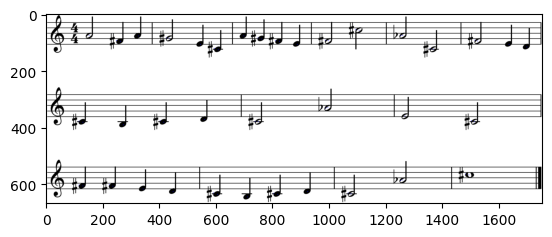

In [45]:
#detect notes2
img2 = cv.imread('polyushka.png')
def MakeNotes2(input_img):
    result=[]
    ## line 
    junk1,lines =LineDetector(input_img)
    # create blunts
    
    bluntN=int(len(lines)/5)
    blunts=[]
    for i in range (bluntN):
        temp_blunt=blunt()
        temp_blunt.lines=[lines[5*i],lines[5*i+1],lines[5*i+2],lines[5*i+3],lines[5*i+4]]
        temp_blunt.average=sum(temp_blunt.lines)/len(temp_blunt.lines)
        print("Average",temp_blunt.average)
        blunts.append(temp_blunt)
 
    ## note
    ## quarters
    template = cv.imread("quarter (1).PNG", cv.IMREAD_GRAYSCALE)
    gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
    threshold = 0.7
    rects,junk2= detectNotes(gray, template, threshold)
    print(len(rects))
    for point in rects:
        temp_note=note()
        temp_note.x=point[0]+14
        temp_note.y=point[1]+62
        temp_note.dur=3
        for i in blunts:
            if(abs(i.average-temp_note.y)<75):
                i.notes.append(temp_note)  
        image2 = cv.circle(input_img, (temp_note.x,temp_note.y), radius=0, color=(0, 0, 255), thickness=2)
    
    ## half
    template = cv.imread("half.PNG", cv.IMREAD_GRAYSCALE)
   # gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
    threshold = 0.71
    rects,junk2= detectNotes(gray, template, threshold)
    print(len(rects))
    for point in rects:
        temp_note=note()
        temp_note.x=point[0]+13
        temp_note.y=point[1]+69
        temp_note.dur=2
        for i in blunts:
            if(abs(i.average-temp_note.y)<75):
                i.notes.append(temp_note)  
        image2 = cv.circle(input_img, (temp_note.x,temp_note.y), radius=0, color=(0, 0, 255), thickness=2)
    #half2
    template = cv.imread("half2.PNG", cv.IMREAD_GRAYSCALE)
   # gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
    threshold = 0.71
    rects,junk2= detectNotes(gray, template, threshold)
    print(len(rects))
    for point in rects:
        temp_note=note()
        temp_note.x=point[0]+13
        temp_note.y=point[1]+12
        temp_note.dur=2
        for i in blunts:
            if(abs(i.average-temp_note.y)<75):
                i.notes.append(temp_note)  
        image2 = cv.circle(input_img, (temp_note.x,temp_note.y), radius=0, color=(0, 0, 255), thickness=2)
    ## dies
    template = cv.imread("dies.PNG", cv.IMREAD_GRAYSCALE)
   # gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
    threshold = 0.7
    rects,junk2= detectNotes(gray, template, threshold)
    print(len(rects))
    for point in rects:
        temp_d=DorB(point[0]+25,point[1]+27,1)
        for i in blunts:
            if(abs(i.average-temp_d.y)<75):
                i.extra.append(temp_d)
        image2 = cv.circle(input_img, (temp_d.x,temp_d.y), radius=0, color=(0, 0, 255), thickness=2)
    ## bemol
    template = cv.imread("bemol.PNG", cv.IMREAD_GRAYSCALE)
   # gray = cv.cvtColor(input_img, cv.COLOR_BGR2GRAY)
    threshold = 0.7
    rects,junk2= detectNotes(gray, template, threshold)
    print(len(rects))
    for point in rects:
        temp_d=DorB(point[0]+25,point[1]+40,0)
        for i in blunts:
            if(abs(i.average-temp_d.y)<75):
                i.extra.append(temp_d)
        image2 = cv.circle(input_img, (temp_d.x,temp_d.y), radius=0, color=(0, 0, 255), thickness=2)
    
    ## whole
    template = cv.imread("whole.PNG", cv.IMREAD_GRAYSCALE)
    threshold = 0.55
    rects,junk2= detectNotes(gray, template, threshold)
    print(len(rects))
    for point in rects:
        temp_note=note()
        temp_note.x=point[0]+14
        temp_note.y=point[1]+11
        temp_note.dur=1
        for i in blunts:
            if(abs(i.average-temp_note.y)<75):
                i.notes.append(temp_note)  
        image2 = cv.circle(input_img, (temp_note.x,temp_note.y), radius=0, color=(0, 0, 255), thickness=2)
    




    for i in blunts:
        print(len(i.notes))
        i.findNotesStr()
        i.AddExtraToNote()   
    
    


    return image2,blunts  
     
        
out2,blunts2=MakeNotes2(img2)
_ = plt.imshow(out2, cmap = plt.cm.gray)
music_to_play2=[]
for i in blunts2:
    i.notes.sort(key=lambda x: x.x, reverse=False)
    for j in i.notes:
        music_to_play2.append([j.id,j.octave,j.dur])
final2=get_music(music_to_play2,44100)
len(music_to_play2)
sd.play(final2)



In [40]:
notes_base = 2**(np.arange(12)/12)*27.5
notes_duration = np.array([3200, 1600, 800, 400, 200, 100])*0.7
notes_ann = ['A', 'A#', 'B', 'C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#']

def sin_wave(f, n, fs):
    x = np.linspace(0, 2*np.pi, n)
    ring = 30 
    xp = np.linspace(0, -1*(n*ring/fs), n)
    y = np.sin(x*f*(n/fs))*np.exp(xp)
    z = np.zeros([n, 2])
    z[:, 0] = y
    z[:, 1] = y
    return z

def play_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]*(fs/1000)), fs)
    sd.play(y, fs)
    sd.wait()
    return 

def put_note(note_id, octave, dur, fs):
    if (note_id < 3) :
        octave += 1
    y = sin_wave(notes_base[note_id]*2**octave, int(notes_duration[dur]*(fs/1000)), fs)
    return y

def get_music(music_notes, fs):
    m = []
    for item in music_notes:
        y = put_note(item[0], item[1], item[2], fs)
        m.append(y)
    m = np.concatenate(m, 0)
    return m

fs1 = 44100
music = [[8, 5, 3], [10, 5, 4], [10, 5, 4], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], [10, 5, 3], 
        [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [11, 5, 4], [4, 5, 4], [3, 5, 3], 
        [8, 5, 4], [8, 5, 4], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], [8, 5, 3], 
        [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [10, 5, 4], [3, 5, 4], [1, 4, 3]]

y = get_music(music, fs1)
sd.play(y, fs1)

In [46]:
write("polyushka.wav", 44100, final2.astype(np.float32))